In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd
import os
import sys
import glob

# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)

<module 'pdo_functions' from '/scratch/ivyglade/pdo/pdo_functions.py'>

In [2]:
# Open data
u_200 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/u_200_monthly/u_200_mam_1940-2024.nc')['__xarray_dataarray_variable__']
v_200 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/v_200_monthly/v_200_mam_1940-2024.nc')['__xarray_dataarray_variable__']
u_500 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/u_500_monthly/u_500_mam_1940-2024.nc')['__xarray_dataarray_variable__']
v_500 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/v_500_monthly/v_500_mam_1940-2024.nc')['__xarray_dataarray_variable__']
u_850 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/u_850_monthly/u_850_mam_1940-2024.nc')['__xarray_dataarray_variable__']
v_850 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/v_850_monthly/v_850_mam_1940-2024.nc')['__xarray_dataarray_variable__']
# z_500 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/Z_500_monthly/Z_500_mam_1940-2024.nc')['__xarray_dataarray_variable__']
tcwv  = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/tcwv_monthly/tcwv_monthly_mam_1940-2024.nc')['TCWV']

In [3]:
tcwv_conus = tcwv.sel(latitude=slice(49, 24)).sel(longitude=slice(235, 294))

In [4]:
tcwv_conus_mam = tcwv_conus.sel(time=tcwv_conus.time.dt.month.isin([3, 4, 5]))

In [5]:
# Resample to seasonal averages
u_200_szn = u_200.resample(time='YE').mean()
v_200_szn = v_200.resample(time='YE').mean()
u_500_szn = u_500.resample(time='YE').mean()
v_500_szn = v_500.resample(time='YE').mean()
u_850_szn = u_850.resample(time='YE').mean()
v_850_szn = v_850.resample(time='YE').mean()
# z_500_szn = z_500.resample(time='YE').mean()
tcwv_szn = tcwv_conus_mam.resample(time='YE').mean()

In [6]:
# Calculate mean wind
wind_200 = np.sqrt(u_200_szn **2 + v_200_szn **2)
wind_850 = np.sqrt(u_850_szn **2 + v_850_szn **2)
wind_500 = np.sqrt(u_500_szn **2 + v_500_szn **2)

In [7]:
# Detrend
wind_200_de = pdo_functions.detrend_dim(wind_200, 'time', 2)
wind_500_de = pdo_functions.detrend_dim(wind_500, 'time', 2)
wind_850_de = pdo_functions.detrend_dim(wind_850, 'time', 2)
# z_500_de = pdo_functions.detrend_dim(z_500_szn, 'time', 2)
u_850_de = pdo_functions.detrend_dim(u_850_szn, 'time', 2)
v_850_de = pdo_functions.detrend_dim(v_850_szn, 'time', 2)
tcwv_de = pdo_functions.detrend_dim(tcwv_szn, 'time', 2)

In [8]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1870, 2024)

oni = pdo_functions.oni_moving_base(sst)

In [9]:
# 3- month rolling mean
oni_rolling = oni.rolling(time=3, center=True).mean()
oni_rolling_1940_2024 = oni_rolling.sel(time=oni_rolling.time.dt.year.isin(np.arange(1940, 2025, 1)))
oni_rolling_1940_2024_mam = oni_rolling_1940_2024.sel(time=oni_rolling_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

# Calculating when El Nino and La Nina events occur
oni_calc = np.zeros((1668))
for i in range(1668):
    if i < 5:
        continue
    else:
        if (oni_rolling[(i-4)] > 0.5) & (oni_rolling[(i-3)] > 0.5) & (oni_rolling[(i-2)] > 0.5) & (oni_rolling[(i-1)] > 0.5) & (oni_rolling[i] > 0.5):
            oni_calc[i] = 1
        elif (oni_rolling[(i-4)] < -0.5) & (oni_rolling[(i-3)] < -0.5) & (oni_rolling[(i-2)] < -0.5) & (oni_rolling[(i-1)] < -0.5) & (oni_rolling[i] < -0.5):
            oni_calc[i] = -1
        else:
            continue

# Coonvert to XR
oni_calc_xr = xr.DataArray(oni_calc, coords={'time':oni['time']}, dims=['time'])

# 1940-2024 only
oni_1940_2024 = oni_calc_xr.sel(time=oni_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
oni_1940_2024_mam = oni_1940_2024.sel(time=oni_1940_2024.time.dt.month.isin([3, 4, 5]))

# Need to calculate when El Nino/La Nina Occurs in a given year
oni_1940_2024_mam_ann = np.zeros((85))
for i in range(85):
    if oni_1940_2024_mam[i*3: (i+1)*3].sum(axis=0) > 0:
        oni_1940_2024_mam_ann[i] = 1

    elif oni_1940_2024_mam[i*3: (i+1)*3].sum(axis=0) < 0:
        oni_1940_2024_mam_ann[i] = -1

    else:
        continue

In [10]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':sst['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM and take seasonal averages
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

# aligning time arrays with that of CAPE
pdo_1940_2024_mam['time'] = u_500_szn['time']

oni_rolling_1940_2024_mam['time'] = u_500_szn['time']

oni_ann_xr = xr.DataArray(oni_1940_2024_mam_ann, coords={'time':u_500_szn['time']}, dims=['time'])

In [13]:
# Compositing
wind_200_pos_pdo = xr.where(pdo_1940_2024_mam > 0, wind_200_de, np.nan).dropna(dim='time')
wind_200_neg_pdo = xr.where(pdo_1940_2024_mam < 0, wind_200_de, np.nan).dropna(dim='time')

wind_200_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, wind_200_de, np.nan).dropna(dim='time')
wind_200_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, wind_200_de, np.nan).dropna(dim='time')

wind_200_pos_nino = xr.where(oni_ann_xr == 1, wind_200_de, np.nan).dropna(dim='time')
wind_200_neg_nina = xr.where(oni_ann_xr == -1, wind_200_de, np.nan).dropna(dim='time')

wind_200_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), wind_200_de, np.nan).dropna(dim='time')
wind_200_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), wind_200_de, np.nan).dropna(dim='time')

wind_500_pos_pdo = xr.where(pdo_1940_2024_mam > 0, wind_500_de, np.nan).dropna(dim='time')
wind_500_neg_pdo = xr.where(pdo_1940_2024_mam < 0, wind_500_de, np.nan).dropna(dim='time')

wind_500_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, wind_500_de, np.nan).dropna(dim='time')
wind_500_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, wind_500_de, np.nan).dropna(dim='time')

wind_500_pos_nino = xr.where(oni_ann_xr == 1, wind_500_de, np.nan).dropna(dim='time')
wind_500_neg_nina = xr.where(oni_ann_xr == -1, wind_500_de, np.nan).dropna(dim='time')

wind_500_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), wind_500_de, np.nan).dropna(dim='time')
wind_500_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), wind_500_de, np.nan).dropna(dim='time')

wind_850_pos_pdo = xr.where(pdo_1940_2024_mam > 0, wind_850_de, np.nan).dropna(dim='time')
wind_850_neg_pdo = xr.where(pdo_1940_2024_mam < 0, wind_850_de, np.nan).dropna(dim='time')

wind_850_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, wind_850_de, np.nan).dropna(dim='time')
wind_850_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, wind_850_de, np.nan).dropna(dim='time')

wind_850_pos_nino = xr.where(oni_ann_xr == 1, wind_850_de, np.nan).dropna(dim='time')
wind_850_neg_nina = xr.where(oni_ann_xr == -1, wind_850_de, np.nan).dropna(dim='time')

wind_850_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), wind_850_de, np.nan).dropna(dim='time')
wind_850_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), wind_850_de, np.nan).dropna(dim='time')

# z_500_pos_pdo = xr.where(pdo_1940_2024_mam > 0, z_500_de, np.nan).dropna(dim='time')
# z_500_neg_pdo = xr.where(pdo_1940_2024_mam < 0, z_500_de, np.nan).dropna(dim='time')

# z_500_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, z_500_de, np.nan).dropna(dim='time')
# z_500_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, z_500_de, np.nan).dropna(dim='time')

# z_500_pos_nino = xr.where(oni_ann_xr == 1, z_500_de, np.nan).dropna(dim='time')
# z_500_neg_nina = xr.where(oni_ann_xr == -1, z_500_de, np.nan).dropna(dim='time')

# z_500_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), z_500_de, np.nan).dropna(dim='time')
# z_500_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), z_500_de, np.nan).dropna(dim='time')

u_850_pos_pdo = xr.where(pdo_1940_2024_mam > 0, u_850_de, np.nan).dropna(dim='time')*land
u_850_neg_pdo = xr.where(pdo_1940_2024_mam < 0, u_850_de, np.nan).dropna(dim='time')*land

u_850_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, u_850_de, np.nan).dropna(dim='time')*land
u_850_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, u_850_de, np.nan).dropna(dim='time')*land

u_850_pos_nino = xr.where(oni_ann_xr == 1, u_850_de, np.nan).dropna(dim='time')*land
u_850_neg_nina = xr.where(oni_ann_xr == -1, u_850_de, np.nan).dropna(dim='time')*land

u_850_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), u_850_de, np.nan).dropna(dim='time')*land
u_850_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), u_850_de, np.nan).dropna(dim='time')*land

v_850_pos_pdo = xr.where(pdo_1940_2024_mam > 0, v_850_de, np.nan).dropna(dim='time')*land
v_850_neg_pdo = xr.where(pdo_1940_2024_mam < 0, v_850_de, np.nan).dropna(dim='time')*land

v_850_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, v_850_de, np.nan).dropna(dim='time')*land
v_850_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, v_850_de, np.nan).dropna(dim='time')*land

v_850_pos_nino = xr.where(oni_ann_xr == 1, v_850_de, np.nan).dropna(dim='time')*land
v_850_neg_nina = xr.where(oni_ann_xr == -1, v_850_de, np.nan).dropna(dim='time')*land

v_850_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), v_850_de, np.nan).dropna(dim='time')*land
v_850_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), v_850_de, np.nan).dropna(dim='time')*land

tcwv_pos_pdo = xr.where(pdo_1940_2024_mam > 0, tcwv_de, np.nan).dropna(dim='time')
tcwv_neg_pdo = xr.where(pdo_1940_2024_mam < 0, tcwv_de, np.nan).dropna(dim='time')

tcwv_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, tcwv_de, np.nan).dropna(dim='time')
tcwv_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, tcwv_de, np.nan).dropna(dim='time')

tcwv_pos_nino = xr.where(oni_ann_xr == 1, tcwv_de, np.nan).dropna(dim='time')
tcwv_neg_nina = xr.where(oni_ann_xr == -1, tcwv_de, np.nan).dropna(dim='time')

tcwv_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), tcwv_de, np.nan).dropna(dim='time')
tcwv_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), tcwv_de, np.nan).dropna(dim='time')

In [14]:
def perm_p_vals(comp_data, climo_data, n_resamples):
    diff = comp_data.mean(dim='time') - climo_data.mean(dim='time')

    n_perms = n_resamples
    n_comp = len(comp_data['time'])
    perm_diffs = np.zeros((n_perms, 101, 237))

    for i in range(n_perms):
        fake_idx = np.random.choice(len(climo_data.time), size=n_comp, replace=False)
        fake_comp = climo_data.isel(time=fake_idx)

        perm_diffs[i] = (fake_comp.mean(dim='time') - climo_data.mean(dim='time'))

    p_values = np.mean(np.abs(perm_diffs) >= abs(diff.values), axis=0)

    return p_values

In [15]:
wind_850_pos_pdo_p = perm_p_vals(wind_850_pos_pdo, wind_850_de, 10000)

In [16]:
wind_850_neg_pdo_p = perm_p_vals(wind_850_neg_pdo, wind_850_de, 10000)

In [17]:
wind_850_pos_pdo_neut_oni_p = perm_p_vals(wind_850_pos_pdo_neut_oni, wind_850_de, 10000)

In [18]:
wind_850_neg_pdo_neut_oni_p = perm_p_vals(wind_850_neg_pdo_neut_oni, wind_850_de, 10000)

In [19]:
wind_500_pos_pdo_p = perm_p_vals(wind_500_pos_pdo, wind_500_de, 10000)

In [20]:
wind_500_neg_pdo_p = perm_p_vals(wind_500_neg_pdo, wind_500_de, 10000)

In [21]:
wind_500_pos_pdo_neut_oni_p = perm_p_vals(wind_500_pos_pdo_neut_oni, wind_500_de, 10000)

In [22]:
wind_500_neg_pdo_neut_oni_p = perm_p_vals(wind_500_neg_pdo_neut_oni, wind_500_de, 10000)

In [23]:
wind_200_pos_pdo_p = perm_p_vals(wind_200_pos_pdo, wind_200_de, 10000)

In [24]:
wind_200_neg_pdo_p = perm_p_vals(wind_200_neg_pdo, wind_200_de, 10000)

In [25]:
wind_200_pos_pdo_neut_oni_p = perm_p_vals(wind_200_pos_pdo_neut_oni, wind_200_de, 10000)

In [26]:
wind_200_neg_pdo_neut_oni_p = perm_p_vals(wind_200_neg_pdo_neut_oni, wind_200_de, 10000)

In [27]:
tcwv_pos_pdo_p = perm_p_vals(tcwv_pos_pdo, tcwv_de, 10000)

In [28]:
tcwv_neg_pdo_p = perm_p_vals(tcwv_neg_pdo, tcwv_de, 10000)

In [29]:
tcwv_pos_pdo_neut_oni_p = perm_p_vals(tcwv_pos_pdo_neut_oni, tcwv_de, 10000)

In [30]:
tcwv_neg_pdo_neut_oni_p = perm_p_vals(tcwv_neg_pdo_neut_oni, tcwv_de, 10000)

In [31]:
## SPACER ##

In [32]:
wind_850_pos_pdo_adj_p = pdo_functions.control_FDR(wind_850_pos_pdo_p, 101, 237, 0.05)
wind_850_neg_pdo_adj_p = pdo_functions.control_FDR(wind_850_neg_pdo_p, 101, 237, 0.05)
wind_850_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(wind_850_pos_pdo_neut_oni_p, 101, 237, 0.05)
wind_850_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(wind_850_neg_pdo_neut_oni_p, 101, 237, 0.05)

wind_500_pos_pdo_adj_p = pdo_functions.control_FDR(wind_500_pos_pdo_p, 101, 237, 0.05)
wind_500_neg_pdo_adj_p = pdo_functions.control_FDR(wind_500_neg_pdo_p, 101, 237, 0.05)
wind_500_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(wind_500_pos_pdo_neut_oni_p, 101, 237, 0.05)
wind_500_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(wind_500_neg_pdo_neut_oni_p, 101, 237, 0.05)

wind_200_pos_pdo_adj_p = pdo_functions.control_FDR(wind_200_pos_pdo_p, 101, 237, 0.05)
wind_200_neg_pdo_adj_p = pdo_functions.control_FDR(wind_200_neg_pdo_p, 101, 237, 0.05)
wind_200_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(wind_200_pos_pdo_neut_oni_p, 101, 237, 0.05)
wind_200_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(wind_200_neg_pdo_neut_oni_p, 101, 237, 0.05)

tcwv_pos_pdo_adj_p = pdo_functions.control_FDR(tcwv_pos_pdo_p, 101, 237, 0.05)
tcwv_neg_pdo_adj_p = pdo_functions.control_FDR(tcwv_neg_pdo_p, 101, 237, 0.05)
tcwv_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(tcwv_pos_pdo_neut_oni_p, 101, 237, 0.05)
tcwv_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(tcwv_neg_pdo_neut_oni_p, 101, 237, 0.05)

In [33]:
# significance testing
wind_850_pos_pdo_sig = np.where(wind_850_pos_pdo_p <= wind_850_pos_pdo_adj_p, 1, 0)
wind_850_neg_pdo_sig = np.where(wind_850_neg_pdo_p <= wind_850_neg_pdo_adj_p, 1, 0)
wind_850_pos_pdo_neut_oni_sig = np.where(wind_850_pos_pdo_neut_oni_p <= wind_850_pos_pdo_neut_oni_adj_p, 1, 0)
wind_850_neg_pdo_neut_oni_sig = np.where(wind_850_neg_pdo_neut_oni_p <= wind_850_neg_pdo_neut_oni_adj_p, 1, 0)

wind_500_pos_pdo_sig = np.where(wind_500_pos_pdo_p <= wind_500_pos_pdo_adj_p, 1, 0)
wind_500_neg_pdo_sig = np.where(wind_500_neg_pdo_p <= wind_500_neg_pdo_adj_p, 1, 0)
wind_500_pos_pdo_neut_oni_sig = np.where(wind_500_pos_pdo_neut_oni_p <= wind_500_pos_pdo_neut_oni_adj_p, 1, 0)
wind_500_neg_pdo_neut_oni_sig = np.where(wind_500_neg_pdo_neut_oni_p <= wind_500_neg_pdo_neut_oni_adj_p, 1, 0)

wind_200_pos_pdo_sig = np.where(wind_200_pos_pdo_p <= wind_200_pos_pdo_adj_p, 1, 0)
wind_200_neg_pdo_sig = np.where(wind_200_neg_pdo_p <= wind_200_neg_pdo_adj_p, 1, 0)
wind_200_pos_pdo_neut_oni_sig = np.where(wind_200_pos_pdo_neut_oni_p <= wind_200_pos_pdo_neut_oni_adj_p, 1, 0)
wind_200_neg_pdo_neut_oni_sig = np.where(wind_200_neg_pdo_neut_oni_p <= wind_200_neg_pdo_neut_oni_adj_p, 1, 0)

tcwv_pos_pdo_sig = np.where(tcwv_pos_pdo_p <= tcwv_pos_pdo_adj_p, 1, 0)
tcwv_neg_pdo_sig = np.where(tcwv_neg_pdo_p <= tcwv_neg_pdo_adj_p, 1, 0)
tcwv_pos_pdo_neut_oni_sig = np.where(tcwv_pos_pdo_neut_oni_p <= tcwv_pos_pdo_neut_oni_adj_p, 1, 0)
tcwv_neg_pdo_neut_oni_sig = np.where(tcwv_neg_pdo_neut_oni_p <= tcwv_neg_pdo_neut_oni_adj_p, 1, 0)

In [34]:
# Land mask
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
land = xr.where(land_110.mask_3D(wind_850_pos_pdo, lon_name='longitude', lat_name='latitude')==True, 1, np.nan).squeeze()

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


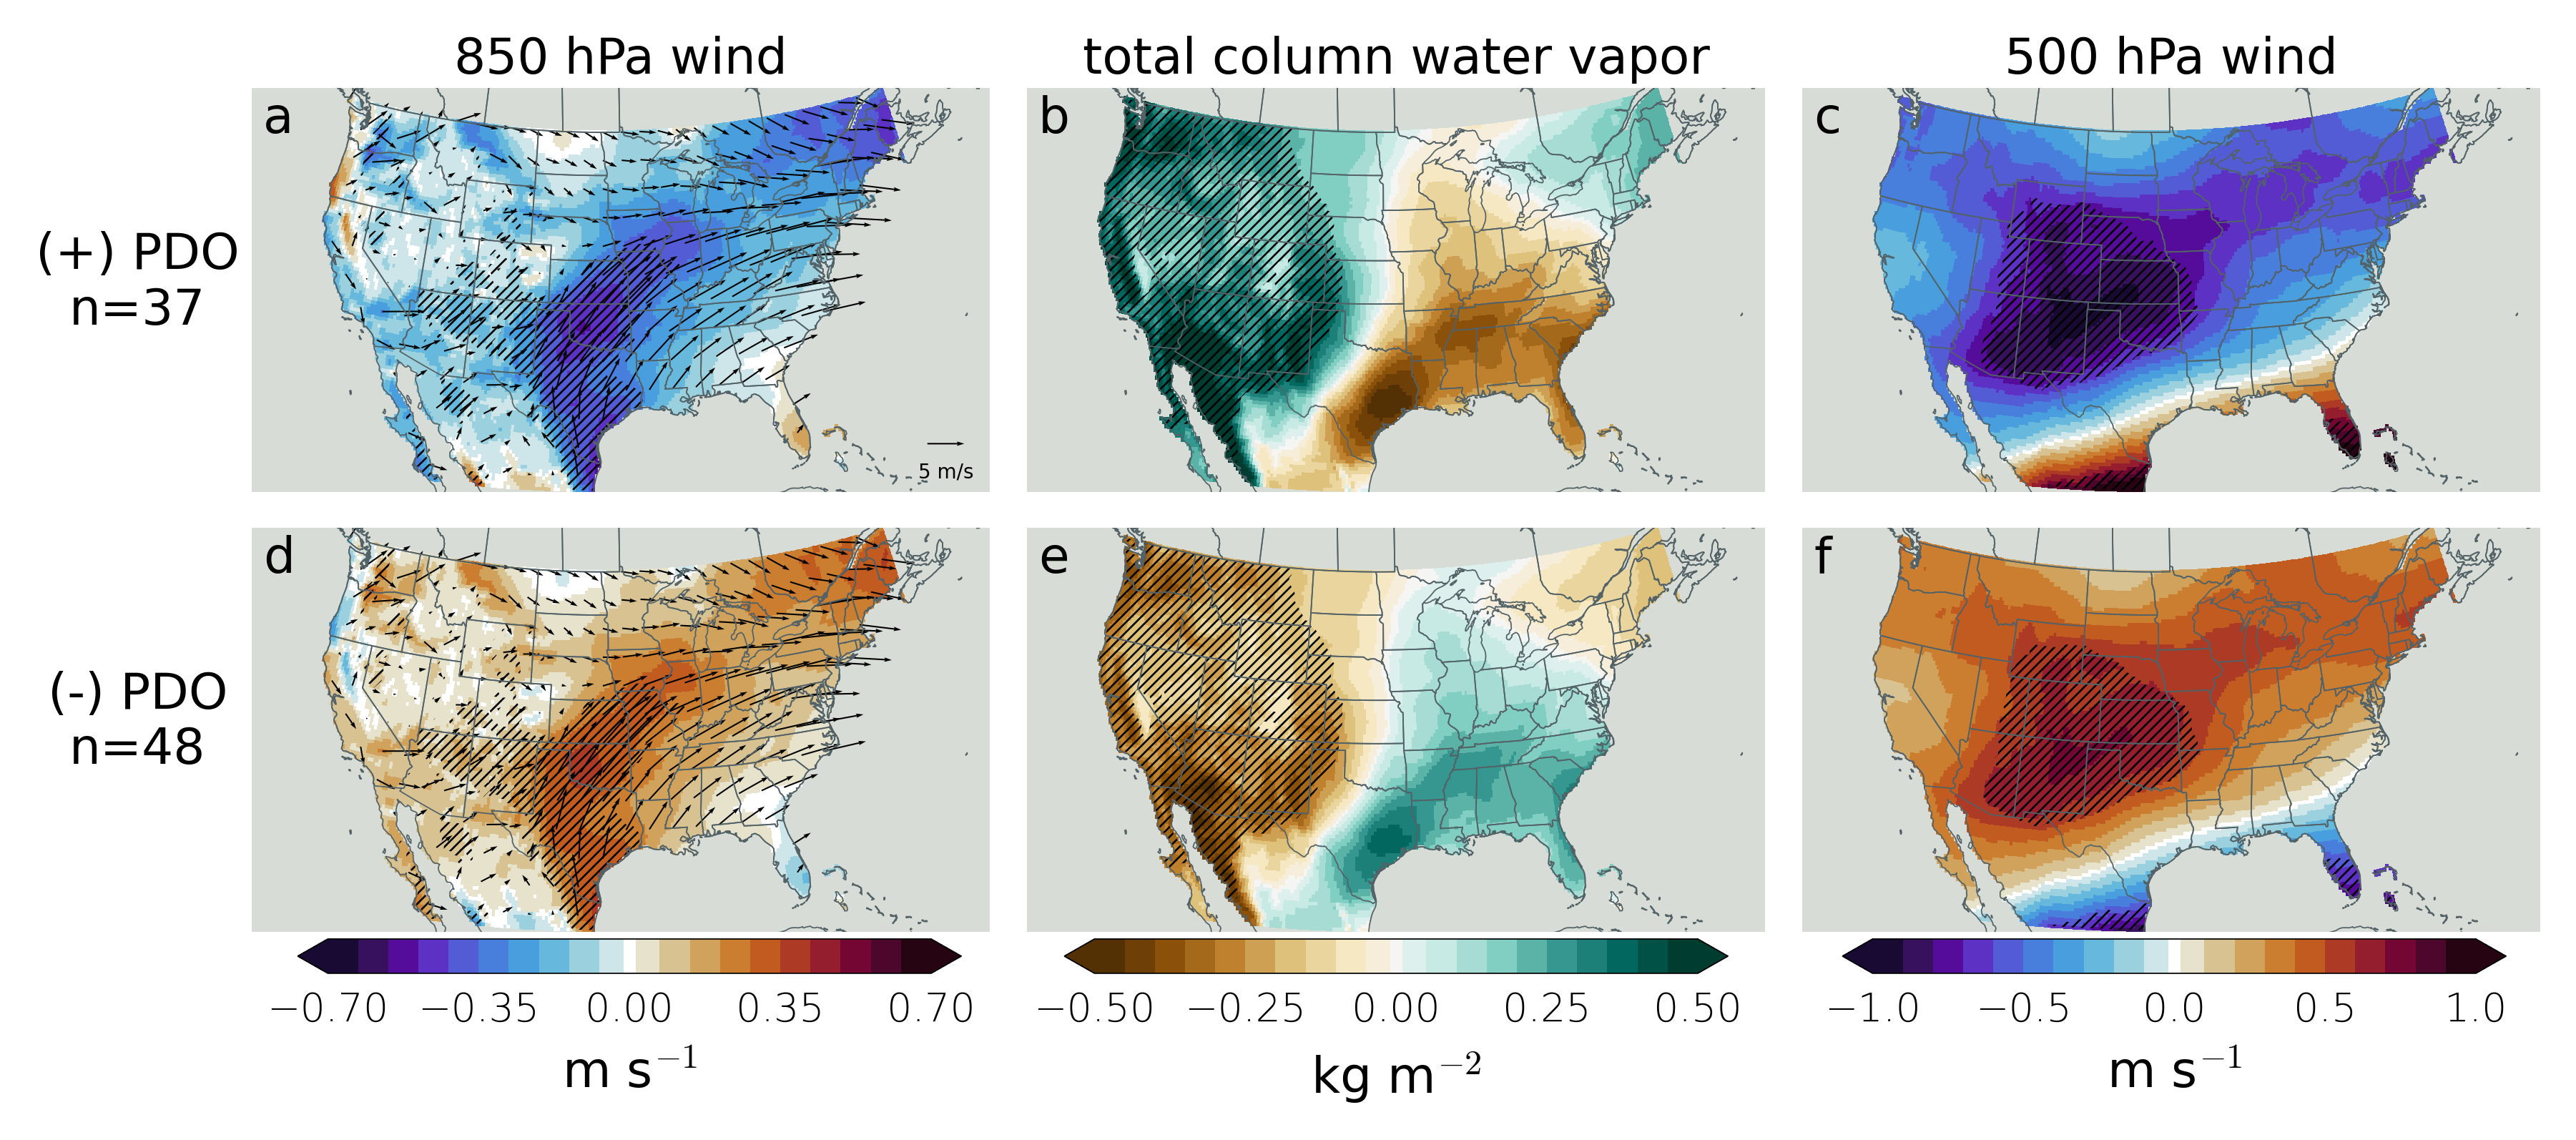

In [36]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

letters = ['a', 'b', 'c', \
           'd', 'e', 'f']

lon = u_500['longitude']
lat = u_500['latitude']

wind_850_bounds = [-0.7, -0.63, -0.56, -0.49, -0.42, -0.35, -0.28, -0.21, -0.14, -0.07, -0.014, 0.014, 0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7]
wind_850_norm = c.BoundaryNorm(wind_850_bounds, plt.get_cmap('cmr.fusion_r').N)

tcwv_bounds = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
tcwv_norm = c.BoundaryNorm(tcwv_bounds, plt.get_cmap('BrBG').N)

wind_500_bounds = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.02, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
wind_500_norm = c.BoundaryNorm(wind_500_bounds, plt.get_cmap('cmr.fusion_r').N)

wind_200_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.04, 0.04, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
wind_200_norm = c.BoundaryNorm(wind_200_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)

ax[0].pcolormesh(lon, lat, wind_850_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)
ax[3].pcolormesh(lon, lat, wind_850_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)

ax[1].pcolormesh(lon, lat, tcwv_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='BrBG', norm=tcwv_norm)
ax[4].pcolormesh(lon, lat, tcwv_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='BrBG', norm=tcwv_norm)

ax[2].pcolormesh(lon, lat, wind_500_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)
ax[5].pcolormesh(lon, lat, wind_500_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)

# ax[3].pcolormesh(lon, lat, wind_200_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)
# ax[7].pcolormesh(lon, lat, wind_200_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)

q = ax[0].quiver(lon[::8], lat[::8], (u_850_szn.mean(dim='time')*land).values[::8, ::8], (v_850_szn.mean(dim='time')*land).values[::8, ::8], width=0.002, scale=100, transform=ccrs.PlateCarree())
ax[3].quiver(lon[::8], lat[::8], (u_850_szn.mean(dim='time')*land).values[::8, ::8], (v_850_szn.mean(dim='time')*land).values[::8, ::8], width=0.002, scale=100, transform=ccrs.PlateCarree())
ax[0].quiverkey(q, X=0.94, Y=0.12, U=5, label='5 m/s', fontproperties={'weight':'normal', 'size':4}, labelpos='S',labelsep=0.05, zorder=100)


ax[0].contourf(lon, lat, wind_850_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[3].contourf(lon, lat, wind_850_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[1].contourf(lon, lat, tcwv_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[4].contourf(lon, lat, tcwv_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[2].contourf(lon, lat, wind_500_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[5].contourf(lon, lat, wind_500_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[3].contourf(lon, lat, wind_200_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[7].contourf(lon, lat, wind_200_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[0].set_title('850 hPa wind', pad=3, fontsize=10)
ax[1].set_title('total column water vapor', pad=3, fontsize=10)
ax[2].set_title('500 hPa wind', pad=3, fontsize=10)
# ax[3].set_title('200 hPa wind', pad=3, fontsize=10)

ax[0].text(-3700000, -100000, f"(+) PDO\nn={len(wind_500_pos_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-3700000, -100000, f"(-) PDO\nn={len(wind_500_neg_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_850_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-.7, -0.35, 0, 0.35, 0.7])
cbar.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='BrBG', norm=tcwv_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-.5, -0.25, 0, 0.25, 0.5])
cbar2.set_label(r'kg m$^{-2}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_500_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-1, -0.5, 0, 0.5, 1])
cbar3.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

# cax4 = plt.axes([0.92, .23, 0.26, 0.02])
# cbar4 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_200_norm), cax=cax4, orientation='horizontal', spacing='proportional', extend='both', \
#                    ticks=[-2, -1, 0, 1, 2])
# cbar4.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
# cbar4.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
# cbar4.outline.set_linewidth(0.25)
# cbar4.outline.set_color('black')
# # cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

In [ ]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

letters = ['a', 'b', 'c', \
           'd', 'e', 'f']

lon = u_500['longitude']
lat = u_500['latitude']

wind_850_bounds = [-0.7, -0.63, -0.56, -0.49, -0.42, -0.35, -0.28, -0.21, -0.14, -0.07, -0.014, 0.014, 0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7]
wind_850_norm = c.BoundaryNorm(wind_850_bounds, plt.get_cmap('cmr.fusion_r').N)

tcwv_bounds = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
tcwv_norm = c.BoundaryNorm(tcwv_bounds, plt.get_cmap('BrBG').N)

wind_500_bounds = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.02, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
wind_500_norm = c.BoundaryNorm(wind_500_bounds, plt.get_cmap('cmr.fusion_r').N)

wind_200_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.04, 0.04, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
wind_200_norm = c.BoundaryNorm(wind_200_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)

ax[0].pcolormesh(lon, lat, wind_850_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)
ax[3].pcolormesh(lon, lat, wind_850_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)

ax[1].pcolormesh(lon, lat, tcwv_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='BrBG', norm=tcwv_norm)
ax[4].pcolormesh(lon, lat, tcwv_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='BrBG', norm=tcwv_norm)

ax[2].pcolormesh(lon, lat, wind_500_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)
ax[5].pcolormesh(lon, lat, wind_500_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)

# ax[3].pcolormesh(lon, lat, wind_200_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)
# ax[7].pcolormesh(lon, lat, wind_200_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)

q = ax[0].quiver(lon[::8], lat[::8], (u_850_szn.mean(dim='time')*land).values[::8, ::8], (v_850_szn.mean(dim='time')*land).values[::8, ::8], width=0.002, scale=100, transform=ccrs.PlateCarree())
ax[3].quiver(lon[::8], lat[::8], (u_850_szn.mean(dim='time')*land).values[::8, ::8], (v_850_szn.mean(dim='time')*land).values[::8, ::8], width=0.002, scale=100, transform=ccrs.PlateCarree())
ax[0].quiverkey(q, X=0.94, Y=0.12, U=5, label='5 m/s', fontproperties={'weight':'normal', 'size':4}, labelpos='S',labelsep=0.05, zorder=100)

ax[0].contourf(lon, lat, wind_850_pos_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[3].contourf(lon, lat, wind_850_neg_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[1].contourf(lon, lat, tcwv_pos_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[4].contourf(lon, lat, tcwv_neg_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[2].contourf(lon, lat, wind_500_pos_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[5].contourf(lon, lat, wind_500_neg_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[3].contourf(lon, lat, wind_200_pos_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[7].contourf(lon, lat, wind_200_neg_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[0].set_title('850 hPa wind', pad=3, fontsize=10)
ax[1].set_title('total column water vapor', pad=3, fontsize=10)
ax[2].set_title('500 hPa wind', pad=3, fontsize=10)
# ax[3].set_title('200 hPa wind', pad=3, fontsize=10)

ax[0].text(-4200000, -400000, f"(+) PDO &\nneutral ONI\nn={len(wind_500_pos_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-4200000, -400000, f"(-) PDO &\nneutral ONI\nn={len(wind_500_neg_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_850_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-.7, -0.35, 0, 0.35, 0.7])
cbar.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='BrBG', norm=tcwv_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-.5, -0.25, 0, 0.25, 0.5])
cbar2.set_label(r'kg m$^{-2}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_500_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-1, -0.5, 0, 0.5, 1])
cbar3.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

# cax4 = plt.axes([0.92, .23, 0.26, 0.02])
# cbar4 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_200_norm), cax=cax4, orientation='horizontal', spacing='proportional', extend='both', \
#                    ticks=[-2, -1, 0, 1, 2])
# cbar4.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
# cbar4.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
# cbar4.outline.set_linewidth(0.25)
# cbar4.outline.set_color('black')
# # cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

NameError: name 'z_500_norm' is not defined

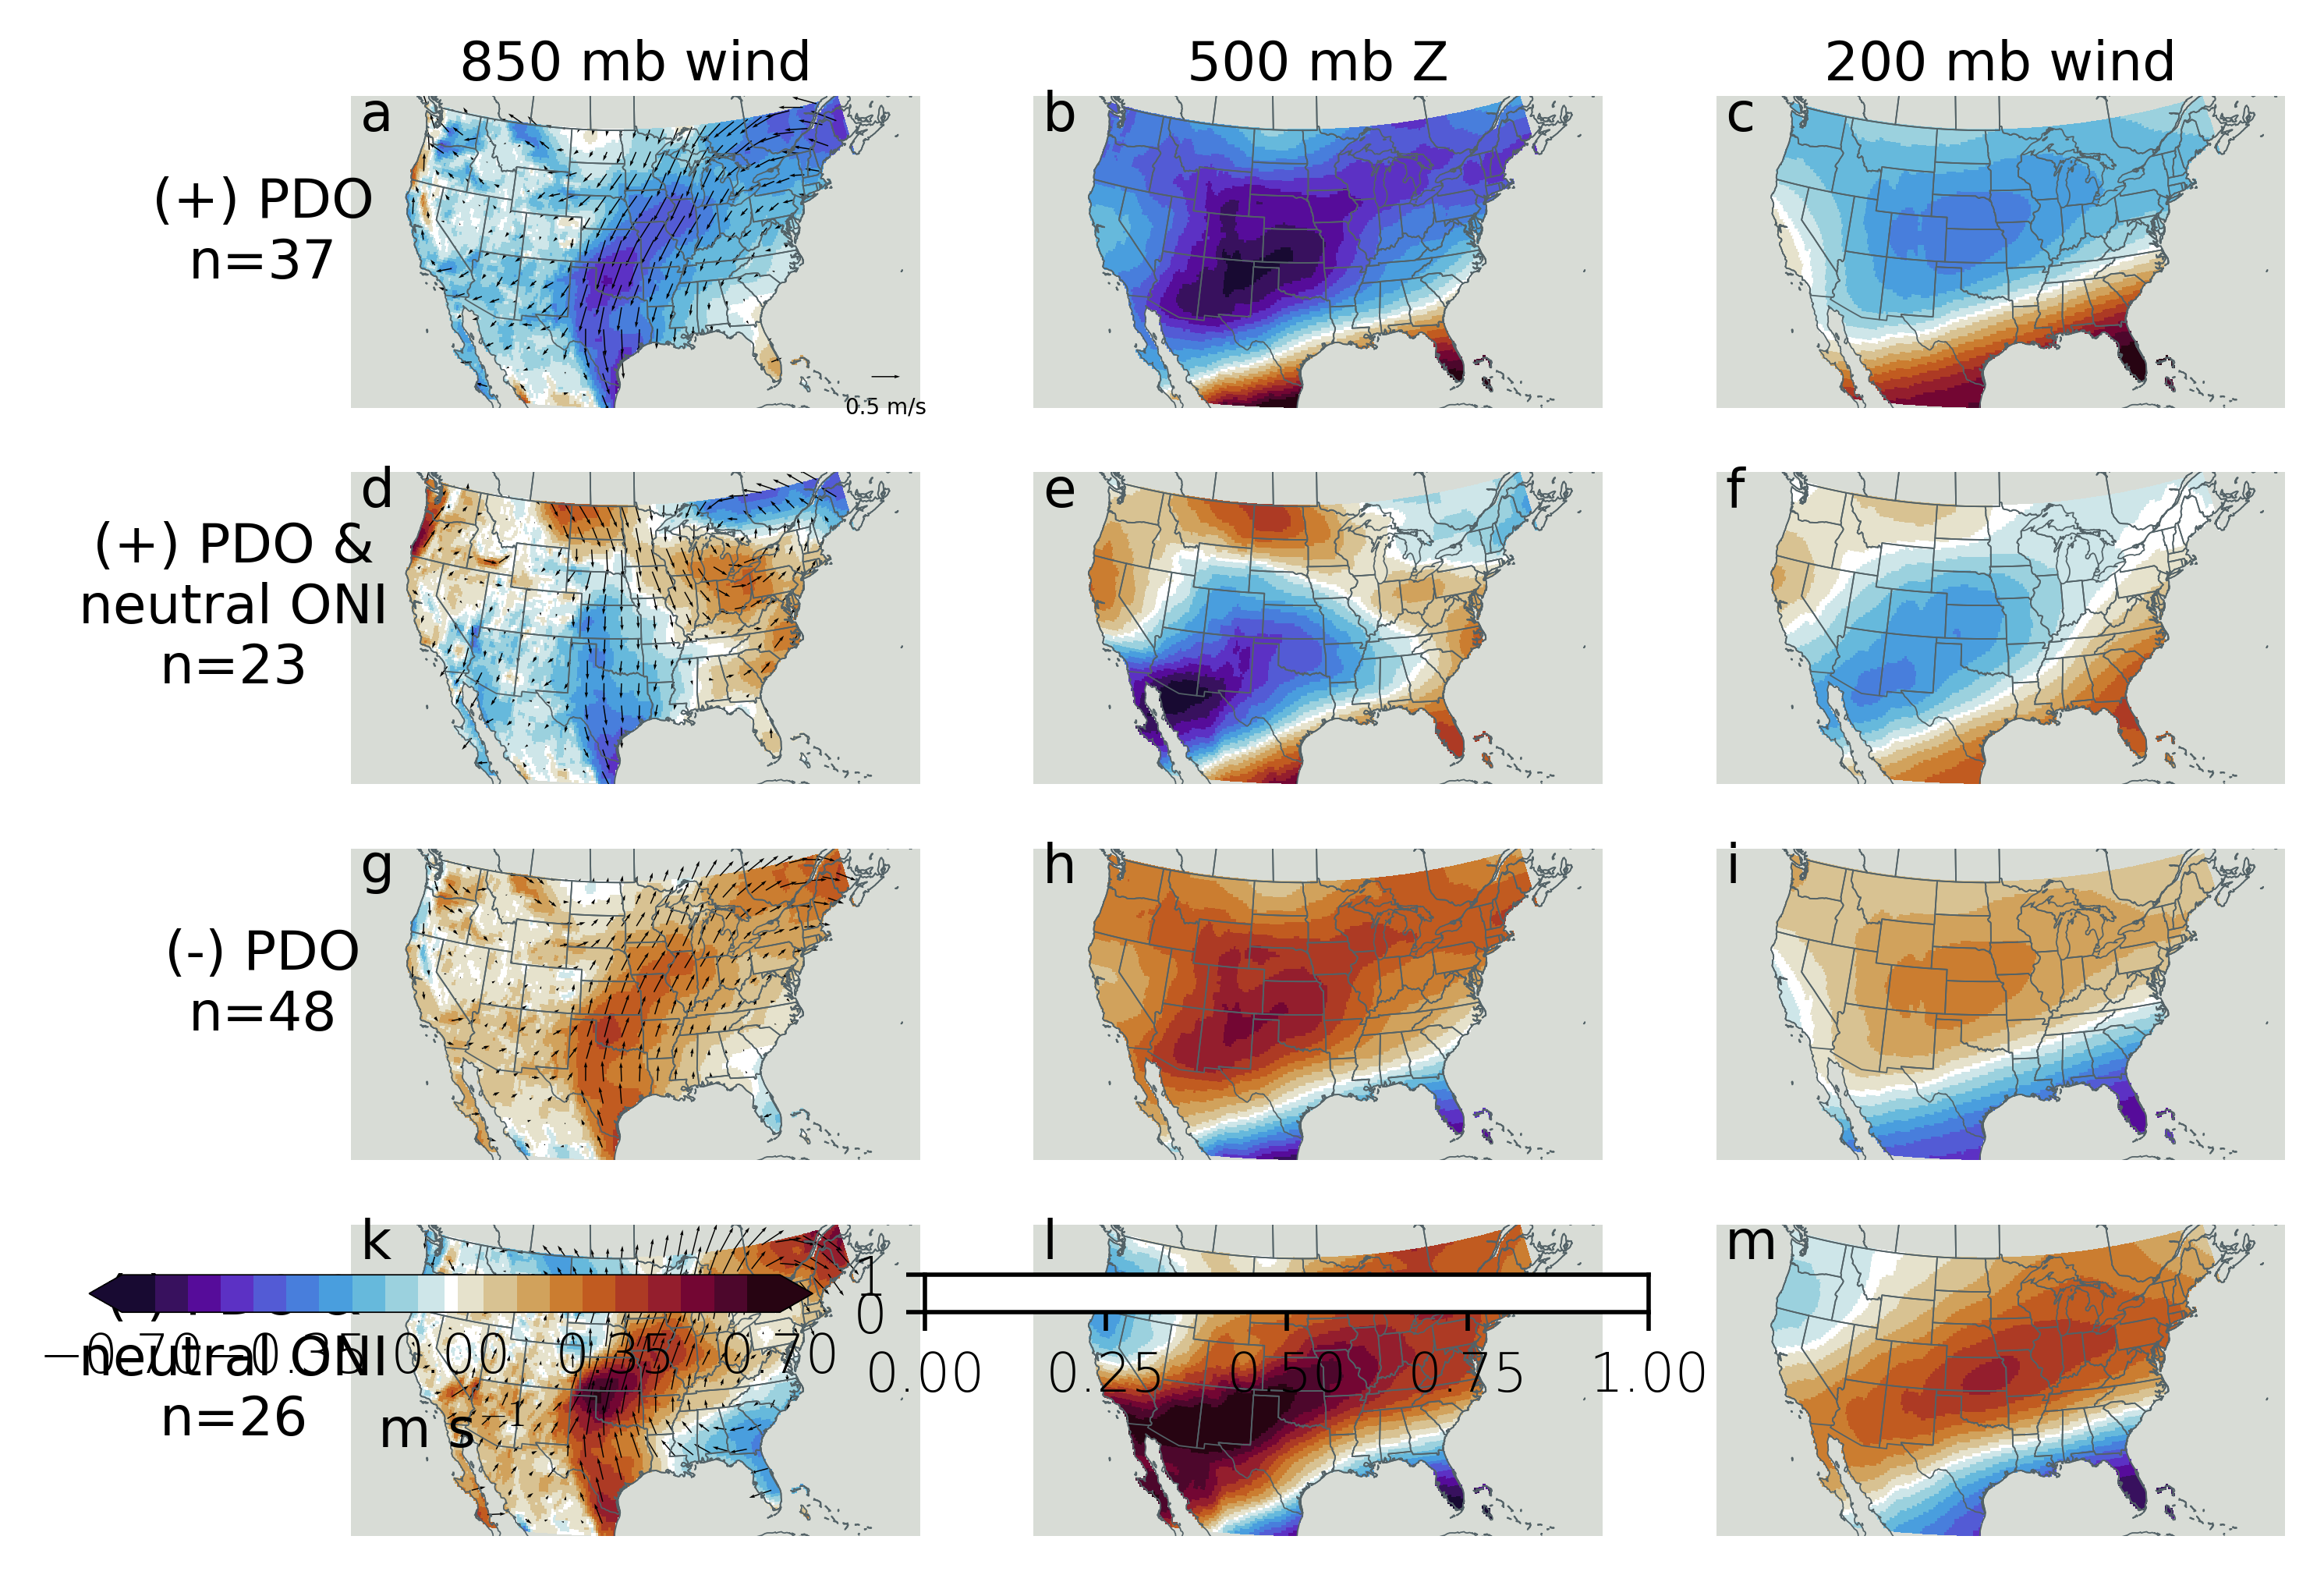

In [14]:
fig, ax = plt.subplots(4, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2], \
      ax[2, 0], ax[2, 1], ax[2, 2], \
      ax[3, 0], ax[3, 1], ax[3, 2]]

lon = u_500['longitude']
lat = u_500['latitude']

letters = ['a', 'b', 'c', \
           'd', 'e', 'f', \
           'g', 'h', 'i', \
           'k', 'l', 'm']

wind_200_bounds = [-3, -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3, -0.06, 0.06, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3]
wind_200_norm = c.BoundaryNorm(wind_200_bounds, plt.get_cmap('cmr.fusion_r').N)

wind_500_bounds = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.02, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
wind_500_norm = c.BoundaryNorm(wind_500_bounds, plt.get_cmap('cmr.fusion_r').N)

wind_850_bounds = [-0.7, -0.63, -0.56, -0.49, -0.42, -0.35, -0.28, -0.21, -0.14, -0.07, -0.014, 0.014, 0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7]
wind_850_norm = c.BoundaryNorm(wind_850_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(12):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)

ax[2].pcolormesh(lon, lat, wind_200_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)
ax[5].pcolormesh(lon, lat, wind_200_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)
ax[8].pcolormesh(lon, lat, wind_200_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)
ax[11].pcolormesh(lon, lat, wind_200_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)

ax[1].pcolormesh(lon, lat, wind_500_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)
ax[4].pcolormesh(lon, lat, wind_500_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)
ax[7].pcolormesh(lon, lat, wind_500_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)
ax[10].pcolormesh(lon, lat, wind_500_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)

ax[0].pcolormesh(lon, lat, wind_850_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)
ax[3].pcolormesh(lon, lat, wind_850_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)
ax[6].pcolormesh(lon, lat, wind_850_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)
ax[9].pcolormesh(lon, lat, wind_850_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)

q = ax[0].quiver(lon[::8], lat[::8], u_850_pos_pdo.mean(dim='time').values[::8, ::8], v_850_pos_pdo.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[3].quiver(lon[::8], lat[::8], u_850_pos_pdo_neut_oni.mean(dim='time').values[::8, ::8], v_850_pos_pdo_neut_oni.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[6].quiver(lon[::8], lat[::8], u_850_neg_pdo.mean(dim='time').values[::8, ::8], v_850_neg_pdo.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[9].quiver(lon[::8], lat[::8], u_850_neg_pdo_neut_oni.mean(dim='time').values[::8, ::8], v_850_neg_pdo_neut_oni.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())

# ax[0].contourf(lon, lat, wind_850_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[3].contourf(lon, lat, wind_850_pos_pdo_neut_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[6].contourf(lon, lat, wind_850_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[9].contourf(lon, lat, wind_850_neg_pdo_neut_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[1].contourf(lon, lat, z_500_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[4].contourf(lon, lat, z_500_pos_pdo_neut_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[7].contourf(lon, lat, z_500_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[10].contourf(lon, lat, z_500_neg_pdo_neut_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[2].contourf(lon, lat, wind_200_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[5].contourf(lon, lat, wind_200_pos_pdo_neut_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[8].contourf(lon, lat, wind_200_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[11].contourf(lon, lat, wind_200_neg_pdo_neut_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[0].quiverkey(q, X=0.94, Y=0.1, U=0.5, label='0.5 m/s', fontproperties={'weight':'normal', 'size':4}, labelpos='S',labelsep=0.05, zorder=100)

ax[0].set_title('850 mb wind', pad=3, fontsize=10)
ax[1].set_title('500 mb Z', pad=3, fontsize=10)
ax[2].set_title('200 mb wind', pad=3, fontsize=10)

ax[0].text(-3700000, -100000, f"(+) PDO\nn={len(wind_500_pos_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-4000000, -400000, f"(+) PDO &\nneutral ONI\nn={len(wind_500_pos_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[6].text(-3700000, -100000, f"(-) PDO\nn={len(wind_500_neg_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[9].text(-4000000, -400000, f"(-) PDO &\nneutral ONI\nn={len(wind_500_neg_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_850_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-.7, -0.35, 0, 0.35, 0.7])
cbar.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=z_500_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-100, -50, 0, 50, 100])
cbar2.set_label(r'm', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_200_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-3, -1.5, 0, 1.5, 3])
cbar3.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=10, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.3, 
                    wspace=0.05, 
                    hspace=0.05)

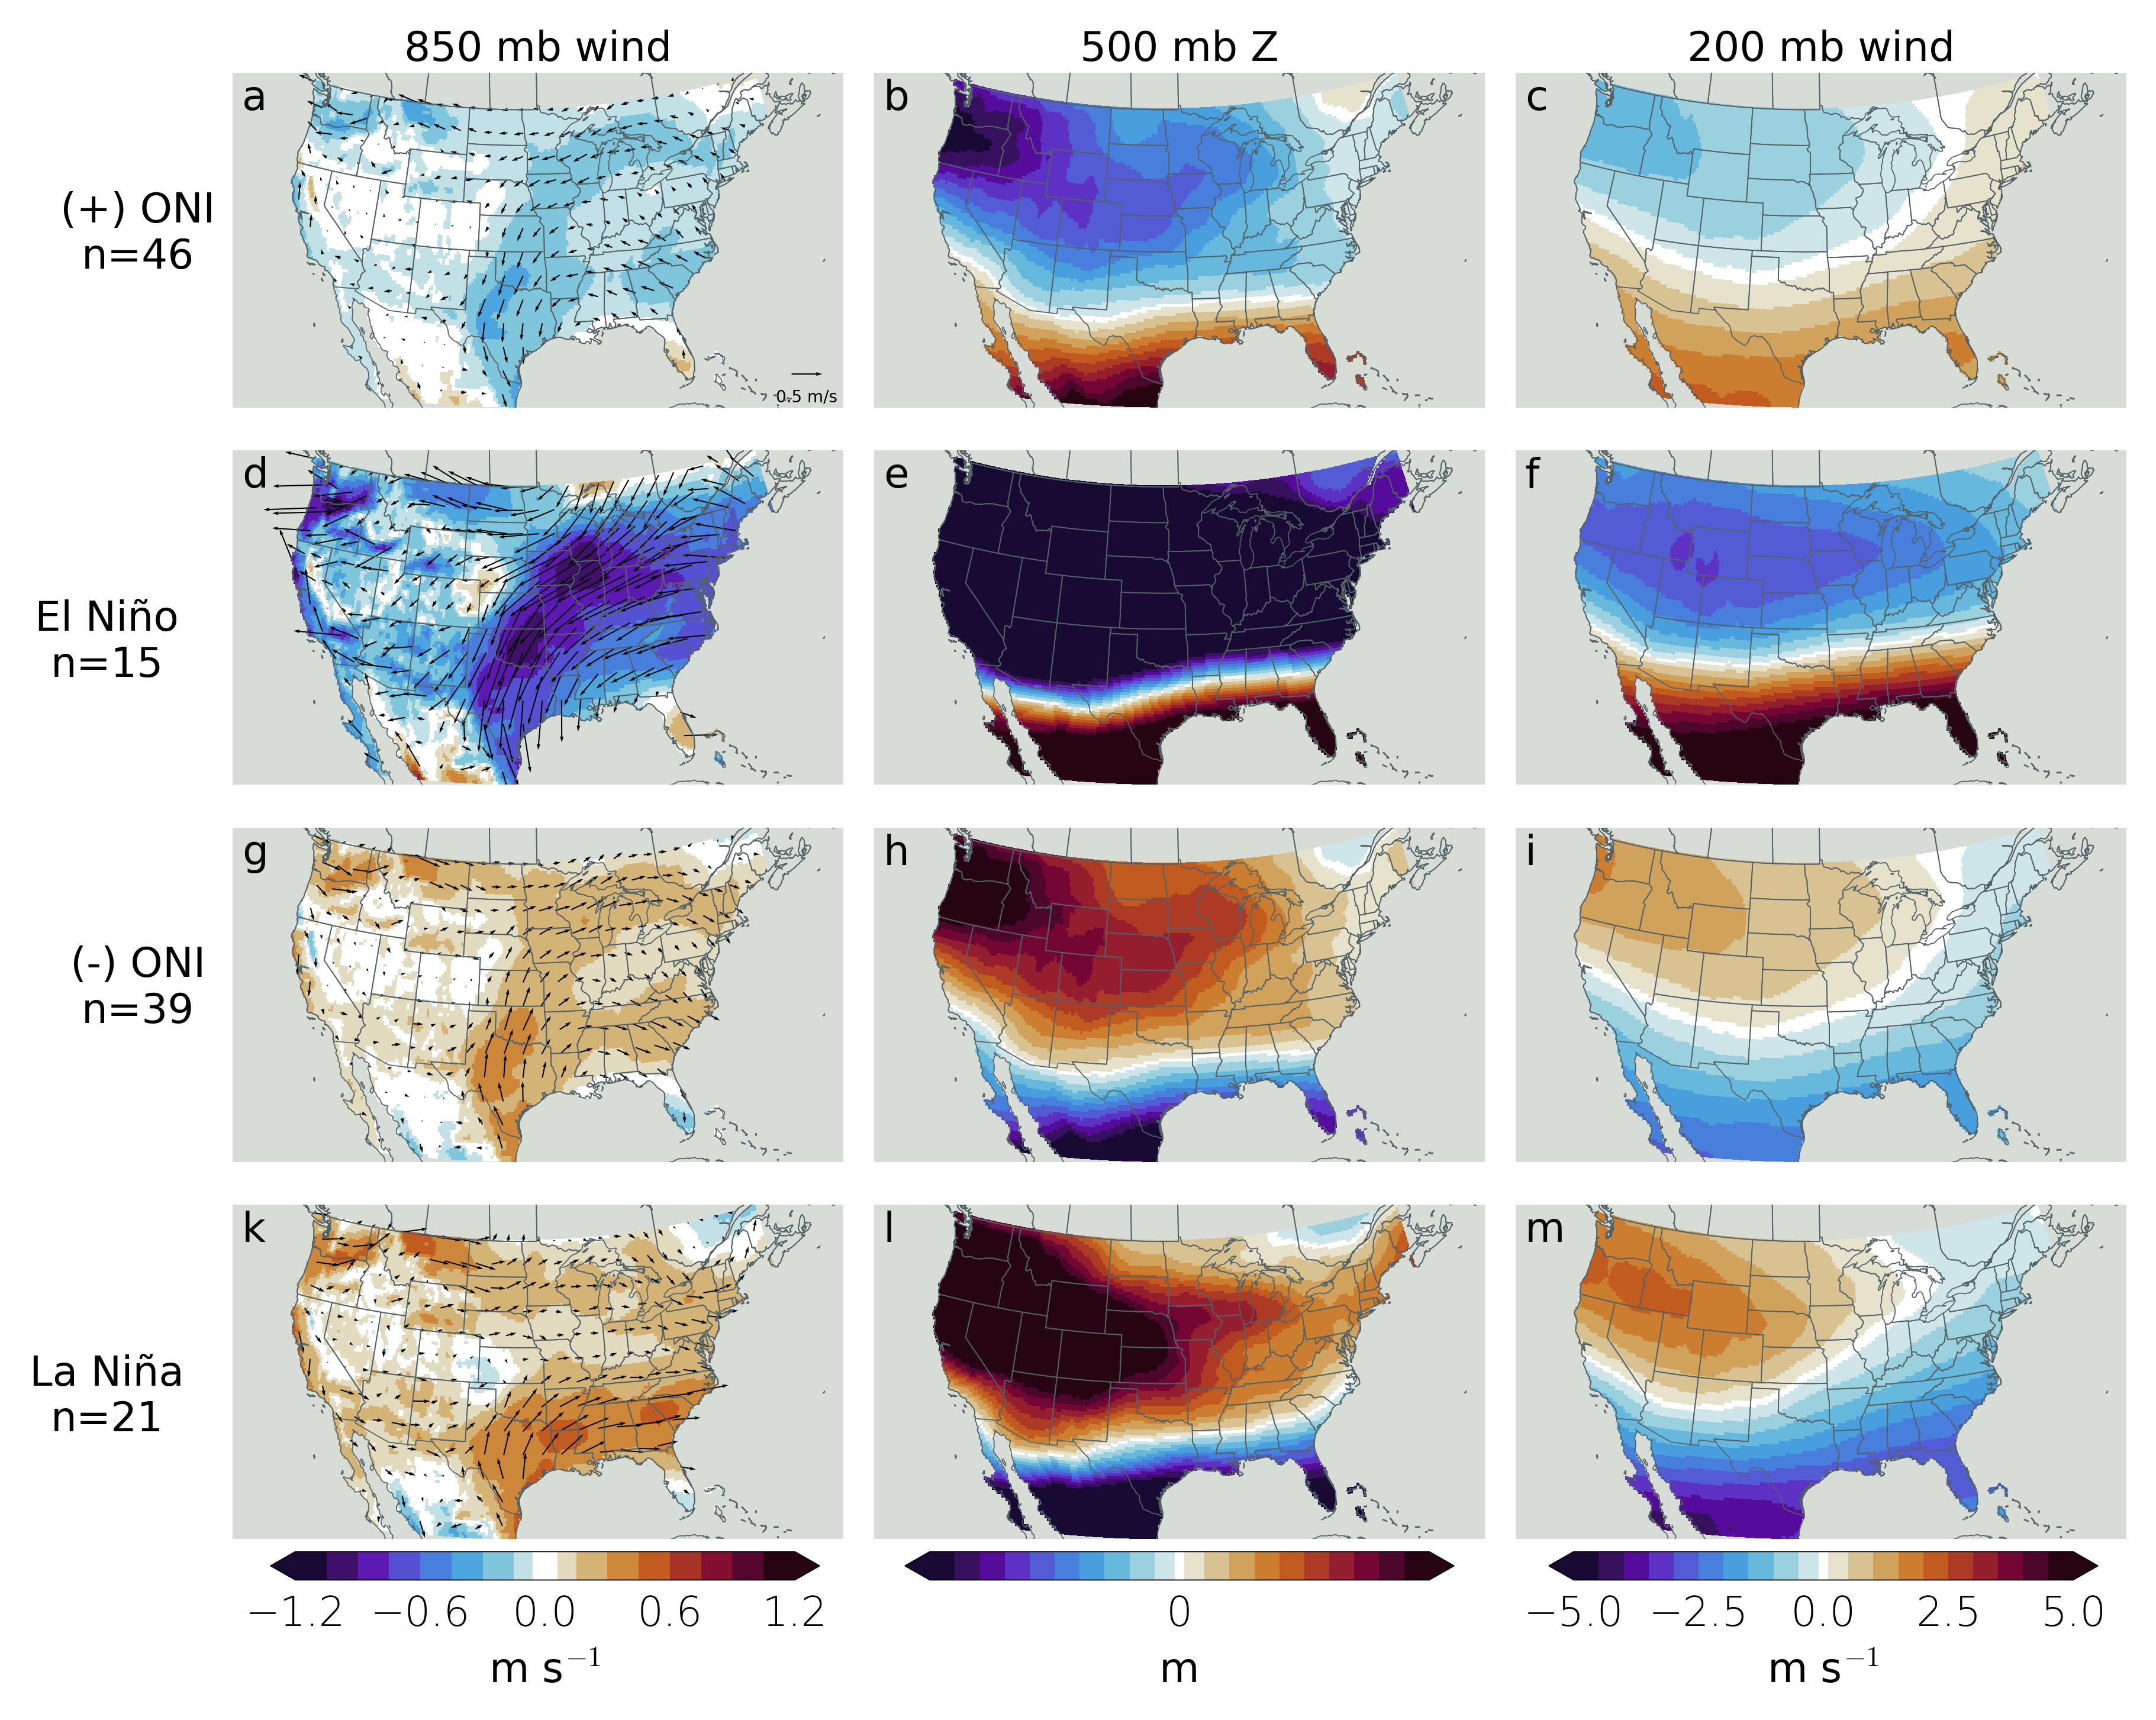

In [16]:
fig, ax = plt.subplots(4, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2], \
      ax[2, 0], ax[2, 1], ax[2, 2], \
      ax[3, 0], ax[3, 1], ax[3, 2]]

lon = wind_500['longitude']
lat = wind_500['latitude']

letters = ['a', 'b', 'c', \
           'd', 'e', 'f', \
           'g', 'h', 'i', \
           'k', 'l', 'm']

wind_200_bounds = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, -0.1, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
wind_200_norm = c.BoundaryNorm(wind_200_bounds, plt.get_cmap('cmr.fusion_r').N)

wind_500_bounds = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.02, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
wind_500_norm = c.BoundaryNorm(wind_500_bounds, plt.get_cmap('cmr.fusion_r').N)

wind_850_bounds = [-1.2, -1.05, -0.9, -0.75, -0.6, -0.45, -0.3, -0.15, -0.06, 0.06, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2]
wind_850_norm = c.BoundaryNorm(wind_850_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(12):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)

ax[2].pcolormesh(lon, lat, wind_200_pos_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)
ax[5].pcolormesh(lon, lat, wind_200_pos_nino.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)
ax[8].pcolormesh(lon, lat, wind_200_neg_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)
ax[11].pcolormesh(lon, lat, wind_200_neg_nina.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_200_norm)

ax[1].pcolormesh(lon, lat, wind_500_pos_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)
ax[4].pcolormesh(lon, lat, wind_500_pos_nino.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)
ax[7].pcolormesh(lon, lat, wind_500_neg_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)
ax[10].pcolormesh(lon, lat, wind_500_neg_nina.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_500_norm)

ax[0].pcolormesh(lon, lat, wind_850_pos_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)
ax[3].pcolormesh(lon, lat, wind_850_pos_nino.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)
ax[6].pcolormesh(lon, lat, wind_850_neg_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)
ax[9].pcolormesh(lon, lat, wind_850_neg_nina.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=wind_850_norm)

q = ax[0].quiver(lon[::8], lat[::8], u_850_pos_oni.mean(dim='time').values[::8, ::8], v_850_pos_oni.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[3].quiver(lon[::8], lat[::8], u_850_pos_nino.mean(dim='time').values[::8, ::8], v_850_pos_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[6].quiver(lon[::8], lat[::8], u_850_neg_oni.mean(dim='time').values[::8, ::8], v_850_neg_oni.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[9].quiver(lon[::8], lat[::8], u_850_neg_nina.mean(dim='time').values[::8, ::8], v_850_neg_nina.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())

ax[0].quiverkey(q, X=0.94, Y=0.1, U=0.5, label='0.5 m/s', fontproperties={'weight':'normal', 'size':4}, labelpos='S',labelsep=0.05, zorder=100)

# ax[0].contourf(lon, lat, wind_850_pos_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[3].contourf(lon, lat, wind_850_pos_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[6].contourf(lon, lat, wind_850_neg_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[9].contourf(lon, lat, wind_850_neg_nina_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[1].contourf(lon, lat, z_500_pos_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[4].contourf(lon, lat, z_500_pos_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[7].contourf(lon, lat, z_500_neg_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[10].contourf(lon, lat, z_500_neg_nina_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[2].contourf(lon, lat, wind_200_pos_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[5].contourf(lon, lat, wind_200_pos_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[8].contourf(lon, lat, wind_200_neg_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[11].contourf(lon, lat, wind_200_neg_nina_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[0].set_title('850 mb wind', pad=3, fontsize=10)
ax[1].set_title('500 mb Z', pad=3, fontsize=10)
ax[2].set_title('200 mb wind', pad=3, fontsize=10)

ax[0].text(-3700000, -100000, f"(+) ONI\nn={len(wind_500_pos_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-4000000, -400000, f"El Ni\u00f1o\nn={len(wind_500_pos_nino)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[6].text(-3700000, -100000, f"(-) ONI\nn={len(wind_500_neg_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[9].text(-4000000, -400000, f"La Ni\u00f1a\nn={len(wind_500_neg_nina)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_850_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-1.2, -0.6, 0, 0.6, 1.2])
cbar.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_500_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-150, -75, 0, 75, 150])
cbar2.set_label(r'm', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=wind_200_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-5, -2.5, 0, 2.5, 5])
cbar3.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=10, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.3, 
                    wspace=0.05, 
                    hspace=0.05)